Data Loading and Importing Relevant Libraries

In [1]:
from pathlib import Path

import numpy as np
# Python library for image augmentation
import albumentations as A

# fastai library for computer vision tasks
from fastai.vision.all import *

import os
import pandas as pd
from transformers import ViTFeatureExtractor, ViTModel, ViTForImageClassification

path = Path('iCloud Drive (Archive)/Desktop/Yale/hpa-single-cell-image-classification')

df = pd.read_csv(path / 'cell_df_train.csv')

Functions for Data Pre-processing

In [2]:
# extract the total number of target labels
labels = [str(i) for i in range(19)]
for x in labels:
    df[x] = df['image_labels'].apply(lambda r: int(x in r.split('|')))
    # print(df[x])

# Here a sample of the dataset has been taken, change frac to 1 to train the entire dataset!
dfs = df.sample(frac=0.1, random_state=42)
dfs = dfs.reset_index(drop=True)
print(len(dfs))


# DATA PRE PROCESSING
# obtain the input images.
def get_x(r):
    return path / 'train_cells' / (r['image_id'] + '_' + str(r['cell_id']) + '.jpg')


# obtain the targets.
def get_y(r):
    return r['image_labels'].split('|')

'''AlbumentationsTransform will perform different transforms over both
   the training and validation datasets '''


class AlbumentationsTransform(RandTransform):
    '''split_idx is None, which allows for us to say when we're setting our split_idx.
       We set an order to 2 which means any resize operations are done first before our new transform. '''
    split_idx, order = None, 2

    def __init__(self, train_aug, valid_aug):
        store_attr()

    # Inherit from RandTransform, allows for us to set that split_idx in our before_call.
    def before_call(self, b, split_idx):
        self.idx = split_idx

    # If split_idx is 0, run the trainining augmentation, otherwise run the validation augmentation.
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)


def get_train_aug(size):
    return A.Compose([
        # allows to combine RandomCrop and RandomScale
        A.RandomResizedCrop(size, size),

        # Transpose the input by swapping rows and columns.
        A.Transpose(p=0.5),

        # Flip the input horizontally around the y-axis.
        A.HorizontalFlip(p=0.5),

        # Flip the input horizontally around the x-axis.
        A.VerticalFlip(p=0.5),

        # Randomly apply affine transforms: translate, scale and rotate the input.
        A.ShiftScaleRotate(p=0.5),

        # Randomly change hue, saturation and value of the input image.
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),

        # Randomly change brightness and contrast of the input image.
        A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),

        # CoarseDropout of the rectangular regions in the image.
        A.CoarseDropout(p=0.5),

        # CoarseDropout of the square regions in the image.
        A.Cutout(p=0.5)])


def get_valid_aug(size):
    return A.Compose([
        # Crop the central part of the input.
        A.CenterCrop(size, size, p=1.),

        # Resize the input to the given height and width.
        A.Resize(size, size)], p=1.)

17404


Data Transformation

/Users/ananyar/anaconda3/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


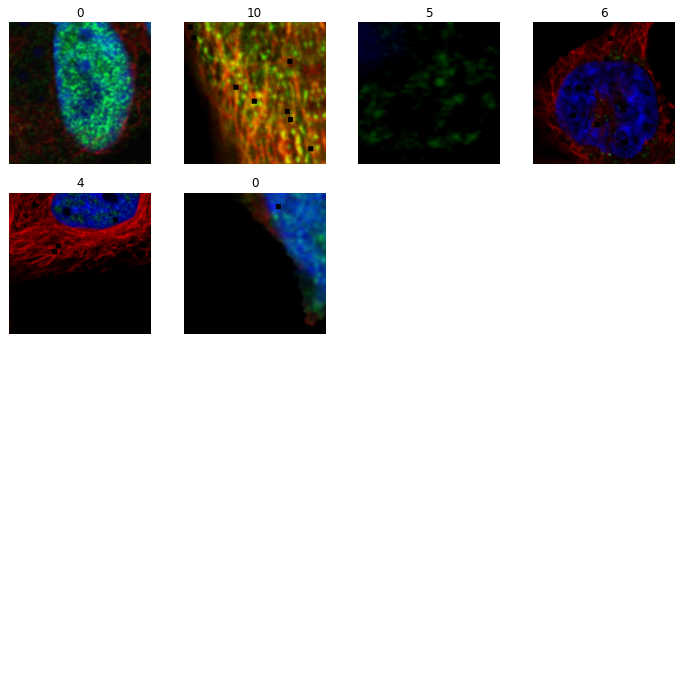

In [3]:
'''The first step item_tfms resizes all the images to the same size (this happens on the CPU) 
   and then batch_tfms happens on the GPU for the entire batch of images. '''
# Transforms we need to do for each image in the dataset
item_tfms = [Resize(224), AlbumentationsTransform(get_train_aug(224), get_valid_aug(224))]

# Transforms that can take place on a batch of images
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

bs = 6

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock(vocab=labels)),  # multi-label target
                   splitter=RandomSplitter(seed=42),  # split data into training and validation subsets.
                   get_x=get_x,  # obtain the input images.
                   get_y=get_y,  # obtain the targets.
                   item_tfms=item_tfms,
                   batch_tfms=batch_tfms
                   )

dls = dblock.dataloaders(dfs, bs=bs)
# print(dls)
# We can call show_batch() to see what a sample of a batch looks like.
dls.show_batch(nrows=4, ncols=4)
plt.show()

Model Creation Part 1

In [4]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]


url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

# pretrained_weights = 'vit'
# tokenizer = TFViTForImageClassification.from_pretrained(pretrained_weights)
# processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

# feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
# # model = ViTModel.from_pretrained('facebook/dino-vitb16')
# inputs = feature_extractor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# last_hidden_states = outputs.last_hidden_state

# learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
# learn = Learner(dls, model, metrics=accuracy_multi)


def get_model(model, pretrained=True):
    # m = model
    # return m
    m = model(pretrained=pretrained)  # loads standard model
    m.avgpool = nn.AdaptiveAvgPool2d(output_size=(100, 100))  # changes one layer
    return m

ResNet50 Creation Part 2 and Finding Optimal Learning Rate

/Users/ananyar/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.009120108559727669)


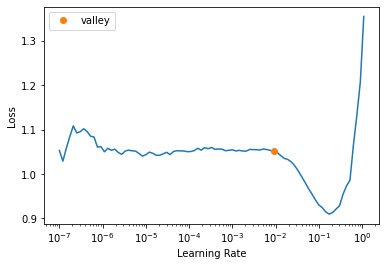

In [5]:
# segment_learner = unet_learner(dls, partial(get_model, model=classif_learner.model), pretrained=True)


# learn = vision_learner(dls, partial(get_model, model=model), pretrained=True, metrics=accuracy_multi)
learn = vision_learner(dls, partial(get_model, model=models.resnet50), metrics=accuracy_multi)
learn.validate()

print(learn.lr_find())
plt.show()

Fine-Tuning ResNet50 Model

In [ ]:
# We can use the fine_tune function to train a model with this given learning rate
learn.fine_tune(2,0.009120108559727669)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.224775,0.211093,0.936088,3:10:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.215588,0.195022,0.938280,2:38:58


In [32]:
from transformers import TrainingArguments, Trainer
import numpy as np
import evaluate

training_args = TrainingArguments(output_dir="test_trainer")

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

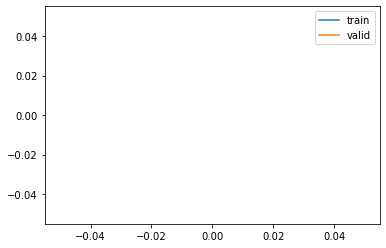

In [45]:
learn.recorder.plot_loss()

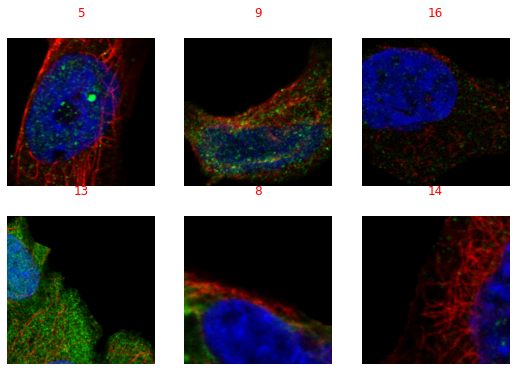

In [43]:
learn.show_results()

In [39]:
from transformers import ViTForImageClassification

import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
        
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vitb16')
model2 = ViTModel.from_pretrained('facebook/dino-vitb16')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model2(**inputs)
last_hidden_states = outputs.last_hidden_state

#learn = Learner(dls, model2, loss_func=CrossEntropyLossFlat(), metrics=Perplexity()).to_fp16()
learn = Learner(dls, model2, metrics=accuracy_multi)

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vitb16 and are newly initialized: ['pooler.dense.weight', 'pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
learn.validate()

AttributeError: 'BaseModelOutputWithPooling' object has no attribute 'view'